In [0]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2019-07-31 04:11:08--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2019-07-31 04:11:13--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  13.8MB/s    in 5.8s    

2019-07-31 04:11:19 (13.4 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [0]:
!unzip train*.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from bs4 import BeautifulSoup

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',header=None, names=cols, encoding = "ISO-8859-1")
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [0]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [0]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [0]:
# take 20k samples for training (10k for each sentiment)
df_train = df[df.sentiment == 0].sample(n=10000,random_state = 114).append(df[df.sentiment == 4].sample(n=10000,random_state = 114))

# take 4k samples for training (2k for each sentiment)
df_test = df[df.sentiment == 0].sample(n=2000,random_state = 44).append(df[df.sentiment == 4].sample(n=2000,random_state = 44))

## Data Preprocessing

In [0]:
# tokenizer
tok = WordPunctTokenizer()
  
# stop words for english
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# @mentions
pat1 = r'@[A-Za-z0-9]+'

# links
pat2 = r'https?://[A-Za-z0-9./]+'

# combined pattern for both
combined_pat = r'|'.join((pat1, pat2))


def tweet_cleaner(text):
  
  # HTML Decoding
  soup = BeautifulSoup(text, 'lxml')
  souped = soup.get_text()

  # Links and @mentions removal
  stripped = re.sub(combined_pat, '', souped)

  # Replace convert the utf BOM characters into utf-8 and remove the \ufffd with '?'
  try:
      clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
  except:
      clean = stripped
      
  # decontract
  def decontract(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
  decontracted = decontract(clean)
  
  # hashtag / numbers removal
  letters_only = re.sub("[^a-zA-Z]", " ", decontracted)
  
  # Remove words with 2 or fewer letters
  removed = re.sub(r'\b\w{1,2}\b', '', letters_only)
  
  # lower
  lower_case = removed.lower()
  
  # tokenize and join together to remove extra white spaces
  words = tok.tokenize(lower_case)

  # stop words removal
  stop_word_removed = [word for word in words if word not in stopword_list]
  
  # lemmatize words using WordNet
  lmtzr = WordNetLemmatizer()
  lemmatized_list = [lmtzr.lemmatize(word) for word in stop_word_removed]
  lemmatized_sentence = ' '.join(lemmatized_list)
  
  return lemmatized_sentence

In [0]:
# apply cleaning on train and test data
df_train.text = df_train.text.apply(tweet_cleaner)
df_test.text = df_test.text.apply(tweet_cleaner)
df_train.head(5)

,sentiment,text
469747,0,annoys announce battle band get excited say au...
595806,0,pooh hole fingertip quilting painful
638343,0,well otitis not know say well ear hurt lot
49981,0,pls dont kill violet already look gruesome
577265,0,job result le free time likely might think


## Data Analysis

In [0]:
def count_words(sentence):
  return len(sentence.split())

def count_chars(sentence):
  return len(sentence)
    
df_train['word_count'] = df_train.text.apply(count_words)
df_train['char_count'] = df_train.text.apply(count_chars)
df_train.head(5)

,sentiment,text,word_count,char_count
469747,0,annoys announce battle band get excited say au...,11,67
595806,0,pooh hole fingertip quilting painful,5,36
638343,0,well otitis not know say well ear hurt lot,9,42
49981,0,pls dont kill violet already look gruesome,7,42
577265,0,job result le free time likely might think,8,42


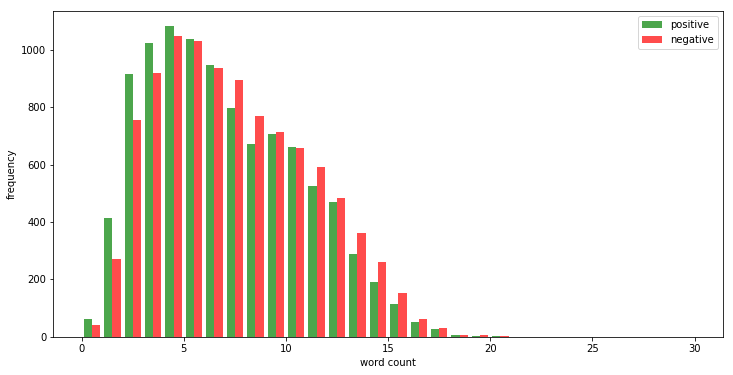

In [0]:
x = df_train['word_count'][df_train.sentiment == 4]
y = df_train['word_count'][df_train.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlabel('word count')
plt.ylabel('frequency')
plt.hist([x, y], color=['g','r'], alpha=0.7, bins=df_train['word_count'].max(), label=['positive','negative'])
plt.legend(loc='upper right')

- most tweets fall between 4–7 words but fairly majority of text on twitter falls between 1-15 words.
- In all, it looks like 1–15 words covers more than 85% of all sentences
- There are more positive tweets with 6 words or less than there are negative ones which does not seem like a big enough difference.
- There are more negative tweets with 6 and more words than there are positive tweets

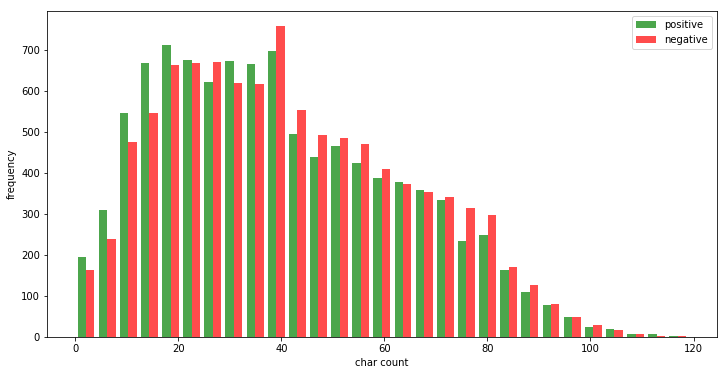

In [0]:
x = df_train['char_count'][df_train.sentiment == 4]
y = df_train['char_count'][df_train.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlabel('char count')
plt.ylabel('frequency')
plt.hist([x, y], color=['g','r'], alpha=0.7, bins=df_train['char_count'].max()//4, label=['positive','negative'])
plt.legend(loc='upper right')

- most of the tweets have 10-80 characters in them and cover more than 90% of the distribution
- below 40 characters there are positive tweets than the negative ones
- all the tweets above 40 characters have more neagtive tweets than positive ones

In [0]:
from collections import Counter

all_words = Counter()
for tweet in df_train.text:
  all_words += Counter(tweet.split())

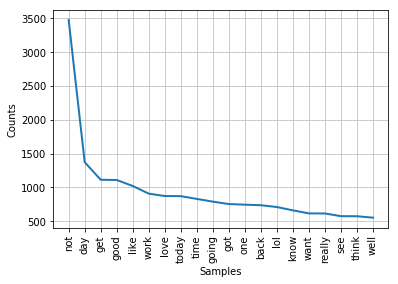

In [0]:

fd = nltk.FreqDist(all_words)
fd.plot(20,cumulative=False)

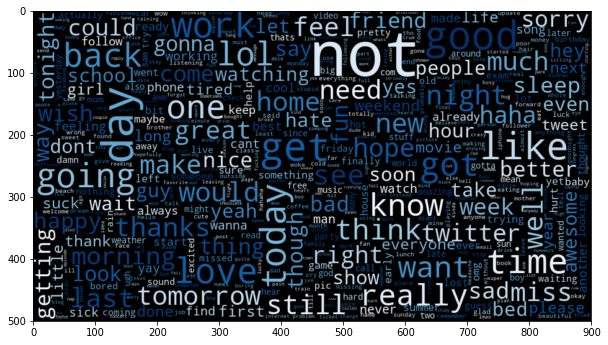

In [0]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(all_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')

## Bag of Words
1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [0]:
# bow transformer
bow_transformer = CountVectorizer(stop_words='english',max_features=10000)

#transfor entire column to bow vector
text_bow = bow_transformer.fit_transform(df_train['text'])

# print total number of vocab words
print(len(bow_transformer.vocabulary_))

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', text_bow.shape)

10000
Shape of Sparse Matrix:  (20000, 10000)


In [0]:
# word embedding using bow
text_bow_matrix = text_bow.todense()
df_train_bow = pd.DataFrame(text_bow_matrix, columns=list(bow_transformer.get_feature_names()))
df_train_bow.head()

,aaa,aaaaaaaaah,aaaaargh,aaah,aaaw,aah,aaron,aawww,abandon,abandoned,abby,abc,ability,abis,abit,able,aboard,abroad,absolut,absolutely,absolutly,abt,abuse,academy,acc,accent,accept,acceptable,acceptance,accepted,accepting,access,accessibility,accident,accidentally,accidently,accomplished,according,account,ace,...,zep,zero,zerogravity,zeta,zettermans,zhakaria,zillion,zillionth,zillow,zimmern,zine,zing,zip,zippy,zit,ziti,zizzazz,zodiac,zoe,zoeboe,zoey,zombie,zomg,zone,zoo,zoolander,zoom,zooooom,zotero,zrbtting,zsirharang,zuckers,zuckerzeugs,zumba,zune,zunehd,zusammen,zzombie,zzz,zzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# tfidf word embedding
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,3), sublinear_tf=True, max_features=10000)
text_tfidf = tfidf_vectorizer.fit_transform(df_train['text'])

import pickle
pickle.dump(tfidf_vectorizer.vocabulary_,open("vocabulary.pkl","wb"))

print(text_tfidf.shape)

(20000, 10000)


In [0]:
tf_idf_matrix = text_tfidf.todense()
df_train_tfidf = pd.DataFrame(tf_idf_matrix, columns=list(bow_transformer.get_feature_names()))

In [0]:
df_train_tfidf.head(5)

,aaa,aaaaaaaaah,aaaaargh,aaah,aaaw,aah,aaron,aawww,abandon,abandoned,abby,abc,ability,abis,abit,able,aboard,abroad,absolut,absolutely,absolutly,abt,abuse,academy,acc,accent,accept,acceptable,acceptance,accepted,accepting,access,accessibility,accident,accidentally,accidently,accomplished,according,account,ace,...,zep,zero,zerogravity,zeta,zettermans,zhakaria,zillion,zillionth,zillow,zimmern,zine,zing,zip,zippy,zit,ziti,zizzazz,zodiac,zoe,zoeboe,zoey,zombie,zomg,zone,zoo,zoolander,zoom,zooooom,zotero,zrbtting,zsirharang,zuckers,zuckerzeugs,zumba,zune,zunehd,zusammen,zzombie,zzz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train_label = df_train.sentiment.replace([0,4],[0,1])
train_label.tail(4)

1451805    1
1242186    1
953903     1
1599270    1
Name: sentiment, dtype: int64

In [0]:
df_test_bow = bow_transformer.transform(df_test.text)
df_test_tfidf = tfidf_vectorizer.transform(df_test.text)

test_label = df_test.sentiment.replace([0,4],[0,1])

## Embedding Visualisation

In [0]:
from sklearn.decomposition import PCA

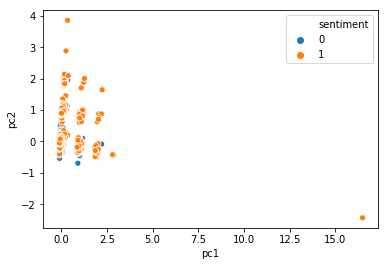

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_train_bow)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['sentiment'] = train_label.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='sentiment')

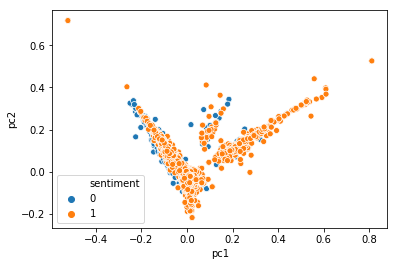

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_train_tfidf)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['sentiment'] = train_label.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='sentiment')

## Modeling

In [0]:
classifier = RandomForestClassifier(n_jobs=-1,n_estimators=50)
classifier.fit(df_train_bow, train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
print(classifier.score(df_test_bow, test_label))

0.7025


In [0]:
classifier = RandomForestClassifier(n_jobs=-1,n_estimators=50)
classifier.fit(df_train_tfidf, train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
print(classifier.score(df_test_tfidf, test_label))

0.73325


- TF-IDF vectors give better accuracy